In [1]:
import sys
sys.path.append("../mypkg")

In [37]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile
from data_gen import get_simu_data
from models.gan_v2 import Generator, Discriminator

In [38]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed

# Params

In [40]:
params = edict()

params.simu_setting = edict()
params.simu_setting.rho = 0.9
params.simu_setting.is_homo = True
params.simu_setting.n = 1000
params.simu_setting.d = 10
params.simu_setting.cal_ratio = 0.25
params.simu_setting.ntest = 1000

params.nrep = 100 # num of reptition for simulation
params.K = 40 # num of sps drawn from q(Y(1)|X)
params.G_model = "gan_v1_demo_G_epoch1000.pth"
#params.G_model = None
params.nz = 10 # the dim of features for GAN

params.gan_training = edict()
# Batch size during training
params.gan_training.batch_size = 32
# Number of training epochs
params.gan_training.num_epochs = 1000
# Learning rate for optimizers
params.gan_training.lr = 0.002
# Beta1 hyperparameter for Adam optimizers
params.gan_training.beta1 = 0.5
params.gan_training.device="cpu"


params.hypo_test = edict()
params.hypo_test.alpha = 0.05 # sig level

params.save_dir = RES_ROOT/"demo2"
if not params.save_dir.exists():
    params.save_dir.mkdir()

# Some fns

In [41]:
def _gen_Y_given_X(X):
    """With generative model f(Y|X), generate Y given X
    """
    if X.ndim == 1:
        X = X.reshape(1, -1)
    X_mul = torch.tensor(X * np.ones((params.K, 1)));
    Zs = torch.randn(params.K, params.nz);
    with torch.no_grad():
        Yhat = netG(X_mul, Zs).view(-1).numpy()
    return Yhat

def _get_pred_intv(X, qv):
    teY_hat = _gen_Y_given_X(X);
    intvs = np.stack([teY_hat-qv, teY_hat+qv]).T
    return merge_intervals(intvs)

def _get_metric(v, intvs):
    if not isinstance(v, np.ndarray):
        v = np.array(v)
    in_sets = np.sum([np.bitwise_and(v>intv[0], v<intv[1]) for intv in intvs], axis=0)
    intvs_len = np.sum([np.diff(intv) for intv in intvs])
    metrics = edict()
    metrics.in_sets = in_sets
    metrics.intvs_len = intvs_len
    return metrics

# Simu

In [42]:
# train q(Y(1)|X)
# I skip this for now, suppose you get one
torch.set_default_dtype(torch.float64)
torch.set_default_tensor_type(torch.DoubleTensor)
netG = Generator(params.simu_setting.d, nz=params.nz);
if params.G_model is not None:
    netG.load_state_dict(torch.load(params.save_dir/params.G_model))
netG.eval();

def _run_fn(rep_ix):
    manualSeed = rep_ix
    random.seed(manualSeed)
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results

    data_train = get_simu_data(n=params.simu_setting.n, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);
    data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);
    n_train = int(data_train.T.sum()*(1-params.simu_setting.cal_ratio));
    tr_idxs = np.sort(np.random.choice(np.where(data_train.T)[0], size=n_train, replace=False));
    cal_idxs = np.setdiff1d(np.where(data_train.T)[0], tr_idxs);
    
    
    # train q(Y(1)|X)
    # I skip this for now, suppose you get one
    torch.set_default_dtype(torch.float64)
    torch.set_default_tensor_type(torch.DoubleTensor)
    #netG = Generator(params.simu_setting.d, nz=params.nz);
    #if params.G_model is not None:
    #    netG.load_state_dict(torch.load(params.save_dir/params.G_model))
    #netG.eval();
    
    
    # propensity score
    # I can use all data in train set (including cal set)
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=0)
    psY = data_train.T.astype(int)
    psX = data_train.X
    clf = clf.fit(psX, psY);
    def psfun(x):
        if x.ndim == 1:
            x = x.reshape(1, -1)
        return clf.predict_proba(x)[:, 1]
    
    
    # weight function
    def wtfun(x):
        # for unconditional weight
        return 1/psfun(x)
    
    
    # get the weight and nonconformity score for each data point in cal set
    wE_set = []
    for cal_idx in cal_idxs:
        cal_X = data_train.X[cal_idx]
        cal_Y = data_train.Y1[cal_idx]
        w = wtfun(cal_X)
        
        # draw K sps from q(Y|X)
        Yhat = _gen_Y_given_X(cal_X)
            
        # the nonconformity score
        E = np.abs(Yhat - cal_Y).min()
        
        wE_set.append([w[0], E])
        
    # now we get weighted quantile
    ws = np.array(wE_set)[:, 0]
    Es = np.array(wE_set)[:, 1];
    qv = weighted_quantile(Es, [(1-params.hypo_test.alpha)*(1/len(Es)+1)], sample_weight=ws);
    
    
    # evaluate on test data
    
    test_res = []
    for te_idx in range(params.simu_setting.ntest):
        teX = data_test.X[te_idx]
        teY1 = data_test.Y1[te_idx]
        tetau = data_test.tau[te_idx]
        intvs = _get_pred_intv(teX, qv)
        test_res.append(_get_metric([teY1, tetau], intvs))
    cv_probs = np.mean([res['in_sets'] for res in test_res], axis=0)
    mlen = np.mean([res['intvs_len'] for res in test_res])
    return (cv_probs, mlen)

In [43]:
with Parallel(n_jobs=20) as parallel:
    test_ress = parallel(delayed(_run_fn)(rep_ix) for rep_ix in tqdm(range(params.nrep), total=params.nrep))

if params.G_model is not None:
    save_pkl(params.save_dir/f"res_{params.G_model.split('.')[0]}_nz{params.nz}.pkl", test_ress, is_force=True)
else:
    save_pkl(params.save_dir/f"res_nz{params.nz}.pkl", test_ress, is_force=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.16it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo2/res_gan_v1_demo_G_epoch1000_nz10.pkl


Load file /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo2/res_gan_v1_demo_G_epoch1000_nz10.pkl


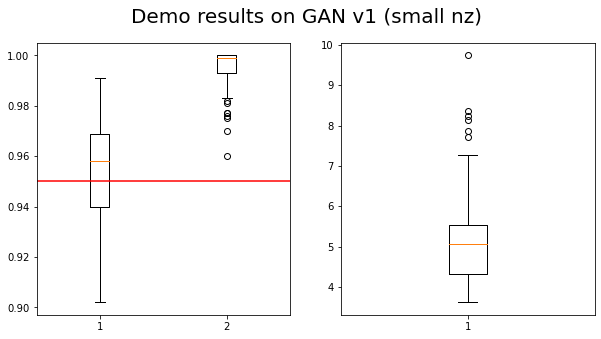

In [44]:
test_ress = load_pkl(params.save_dir/f"res_gan_v1_demo_G_epoch1000_nz10.pkl")
ITE_prob = np.array([res[0][0] for res in test_ress])
CATE_prob = np.array([res[0][1] for res in test_ress])
lens = np.array([res[1] for res in test_ress]);

plt.figure(figsize=[10, 5])
plt.suptitle(f"Demo results on GAN v1 (small nz)", fontsize=20)
plt.subplot(121)
plt.boxplot([ITE_prob, CATE_prob]);
plt.axhline(y=0.95, color="red")
plt.subplot(122)
plt.boxplot([lens]);

Load file /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo1/res_gan_v1_demo_G_nz50.pkl


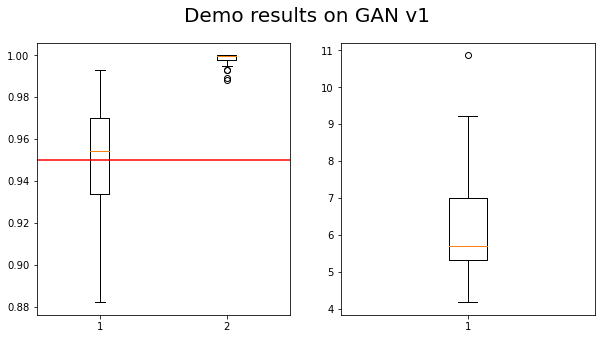

In [26]:
test_ress = load_pkl(params.save_dir/f"res_gan_v1_demo_G_nz50.pkl")
ITE_prob = np.array([res[0][0] for res in test_ress])
CATE_prob = np.array([res[0][1] for res in test_ress])
lens = np.array([res[1] for res in test_ress]);

plt.figure(figsize=[10, 5])
plt.suptitle(f"Demo results on GAN v1", fontsize=20)
plt.subplot(121)
plt.boxplot([ITE_prob, CATE_prob]);
plt.axhline(y=0.95, color="red")
plt.subplot(122)
plt.boxplot([lens]);

Load file /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo1/res_nz10.pkl


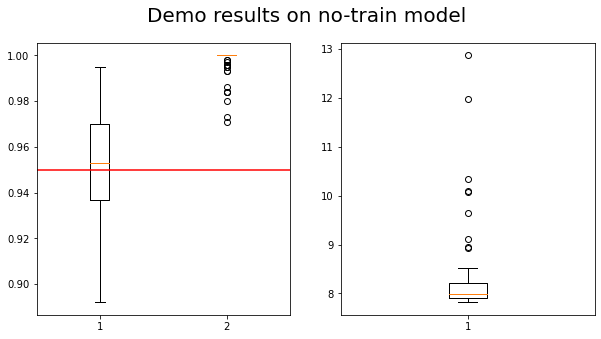

In [16]:
test_ress = load_pkl(params.save_dir/f"res_nz10.pkl")
ITE_prob = np.array([res[0][0] for res in test_ress])
CATE_prob = np.array([res[0][1] for res in test_ress])
lens = np.array([res[1] for res in test_ress]);

plt.figure(figsize=[10, 5])
plt.suptitle(f"Demo results on no-train model", fontsize=20)
plt.subplot(121)
plt.boxplot([ITE_prob, CATE_prob]);
plt.axhline(y=0.95, color="red")
plt.subplot(122)
plt.boxplot([lens]);